In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_op
# from WindPy import *
from functools import reduce
import datetime

In [2]:
from collections import defaultdict
import pymc3 as pm
import scipy.stats as st

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
plt.style.use('seaborn-darkgrid')
print('Running with PyMC3 version v.{}'.format(pm.__version__))

Running with PyMC3 version v.3.4.1


### getdata

In [5]:
### 511880货基；511010债基
funds=["510330.SH","510880.SH","510900.SH","511880.SH","511010.SH","518880.SH"]
risk_funds=["510330.SH","510880.SH","510900.SH","518880.SH"]

In [6]:
def concat_data(columns):
    data_returns={}
    frame=[]
    for item in data.keys():
        data_returns[item]=data[item].loc[:,columns]
        data_returns[item].rename(columns={columns[1]:item,'日期':'date'},inplace=True)
        frame.append(data_returns[item])
    data1 = reduce(lambda left,right: pd.merge(left,right,on='date'), frame)
    data1.set_index('date', inplace=True)
    data1.dropna(inplace=True)
    return data1

In [7]:
data={}
for item in funds:
    name=item.split('.')[0]
    data[name]=pd.read_excel(name+'.xlsx')

In [8]:
### 收益率
data1=concat_data(['日期','收盘价(元)'])
rets = np.log(data1 / data1.shift(1))
rets.dropna(inplace=True)

In [9]:
n_risk=pd.read_excel('n_risk.xlsx',names=['date','interest'])
n_risk['interest']=n_risk['interest']/100
n_risk.dropna(inplace=True)
n_risk.set_index('date', inplace=True)

### bayes_data

In [10]:
def get_data():
    mu_=np.zeros(6)
    cov_=100*np.identity(6)
    nu_=5
    data=np.array(tmp_rets)
    data = np.random.randn(6,6)
    with pm.Model() as model:
        mu = pm.MvNormal('mu', mu=mu_, cov=cov_,shape=6)
        packed_L = pm.LKJCholeskyCov('packed_L', n=6,eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        L = pm.expand_packed_triangular(6, packed_L)
        Σ = pm.Deterministic('Σ', L.dot(L.T))
        n = pm.MvNormal('n', mu=mu,chol=L,observed=data)
        trace = pm.sample(1000)

    ppc = pm.sample_ppc(trace, samples=1000, model=model, size=1000)
    r_matrix=np.asarray(ppc['n'])
    return r_matrix
    

### 求解函数

In [11]:
def fun_utility_max(weights):
        miu_=np.mean(sub_rets)
        utility=np.sum(np.sum((weights*sub_rets),axis=1)-riskaverse*(np.sum(weights*(sub_rets-miu_),axis=1))**2)/number
        return -utility


def get_weights():
    averge_weights=np.zeros((1000,6))
    for i in range(0,1000):
        global sub_rets
        sub_rets=mc_rets[i]
        constraints = ({'type':'eq', 'fun':lambda x: np.sum(x)-1.},)
        bounds = tuple((0,1) for x in range(6))
        weights = np.random.random(6)
        weights /= np.sum(weights)
        initial_guess = weights
        opts = sci_op.minimize(fun=fun_utility_max,
                               x0=initial_guess,
                               method='SLSQP',
                               bounds=bounds,
                               constraints=constraints)
        averge_weights[i]=opts['x']
    return np.mean(averge_weights,axis=0)

### 回测过程

In [12]:
def max_drawdown(timeseries):
    # 回撤结束时间点
    i = np.argmax(np.maximum.accumulate(timeseries) - timeseries)
    # 回撤开始的时间点
    j = np.argmax(timeseries[:i])
    return (float(timeseries[i]) / timeseries[j]) - 1.

In [20]:
date_list=rets.index.tolist()
# real_weights={}
cost=0.0003
number=1000
risks=[0.5,1,2]
real_weights=[]
value=1
with open('bayes_result.csv','w') as f:
    for i in range(591,len(date_list)):
        result_list=[]
        print('还剩%d'%(len(date_list)-i)) 
        riskaverse=0.3
        j=i-591
        day=date_list[i]
        history_day=date_list[i-252]
        yesterday=date_list[i-1]
        tmp_rets=rets.loc[history_day:yesterday,:]
        mc_rets=get_data()
        result=np.array(get_weights())
        real_weights.append(result)
        if j==0:
            change_weight=float(np.sum(abs(real_weights[j]-[0,0,0,0,0,0])))
        else:
            change_weight=float(np.sum(abs(real_weights[j]-real_weights[j-1])))

        rets_change1=float(change_weight*(1-cost)+1-change_weight)
        rets_change2=float(np.sum(real_weights[j]*rets.loc[day,:]))
        
        real_rets=float(rets_change1*rets_change2+rets_change1-1)
        value=value*(1+real_rets)
        
        dayoftest=day.strftime('%Y%m%d')
        result_list.append(str(dayoftest))
        result_list.extend([str(item) for item in result])
        result_list.append(str(1))
        tmp=[str(item) for item in rets.loc[day,:].tolist()]
        result_list.extend(tmp)
        result_list.append(str(float(rets_change1*rets_change2+rets_change1-1)))
        result_list.append(str(value))
        print(dayoftest,value)
        f.write(','.join(result_list)+'\n')


还剩565


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
100%|██████████| 1500/1500 [00:15<00:00, 93.97it/s]
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 1000/1000 [00:00<00:00, 2608.05it/s]


20151231 0.9999887840771959
还剩564


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
100%|██████████| 1500/1500 [00:17<00:00, 87.82it/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 1000/1000 [00:00<00:00, 2599.37it/s]


20160104 0.9852210425517214
还剩563


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
100%|██████████| 1500/1500 [00:15<00:00, 96.16it/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 1000/1000 [00:00<00:00, 2568.10it/s]


20160105 0.9847696445091704
还剩562


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
100%|██████████| 1500/1500 [00:15<00:00, 94.20it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 1000/1000 [00:00<00:00, 2602.51it/s]


20160106 0.9891723720818972
还剩561


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
100%|██████████| 1500/1500 [00:15<00:00, 95.96it/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 1000/1000 [00:00<00:00, 2628.38it/s]


20160107 0.9645019734985886
还剩560


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
100%|██████████| 1500/1500 [00:14<00:00, 101.21it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 1000/1000 [00:00<00:00, 2671.37it/s]


20160108 0.9682456171826439
还剩559


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
100%|██████████| 1500/1500 [00:18<00:00, 79.11it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7026899948798966, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 1000/1000 [00:00<00:00, 2617.82it/s]


20160111 0.9394687730744551
还剩558


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
100%|██████████| 1500/1500 [00:17<00:00, 85.70it/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 1000/1000 [00:00<00:00, 2588.56it/s]


20160112 0.9395945368014291
还剩557


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
100%|██████████| 1500/1500 [00:22<00:00, 67.43it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 1000/1000 [00:00<00:00, 2586.58it/s]


20160113 0.9365120511873815
还剩556


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
100%|██████████| 1500/1500 [00:17<00:00, 85.94it/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 1000/1000 [00:00<00:00, 2497.47it/s]


KeyboardInterrupt: 

In [13]:
draw=np.zeros((3,1000*1000))
date_list=rets.index.tolist()
# real_weights={}
cost=0.0003
number=1000
risks=[0.5,1,2]
real_weights=[]
value=1

for i in range(591,593):
    result_list=[]
    print('还剩%d'%(len(date_list)-i)) 
    riskaverse=0.3
    j=i-591
    day=date_list[i]
    history_day=date_list[i-252]
    yesterday=date_list[i-1]
    tmp_rets=rets.loc[history_day:yesterday,:]
    mc_rets=get_data()
    tmp=[]
    for x in range(1000):
        for y in range(1000):
            tmp.append(mc_rets[x][y][1])
    draw[i-591]=np.array(tmp)
        

还剩565


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
 35%|███▌      | 529/1500 [00:06<00:12, 80.28it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '2191' (I am process '2192')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/zhangyidan/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2191' (I am process '2193')
 98%|█████████▊| 1469/1500 [00:16<00:00, 90.25it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '2192' (I am process '2193')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/zhangyidan/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir
100%|██████████| 1500/1500 [00:16<00:00, 89.72it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparam

还剩564


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
100%|██████████| 1500/1500 [00:16<00:00, 89.28it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 1000/1000 [00:00<00:00, 2571.55it/s]


In [15]:
draw1=pd.DataFrame(draw,index=date_list[591:594])

In [ ]:
import seaborn as sns
ax = sns.boxplot(draw1.iloc[1,:],draw1.iloc[1,:])

In [ ]:

value=np.cumprod(np.array(real_rets)+1)
for index in range(len(value)):
    if index<3:
        real_drawdown.append(0)
    else:
        real_drawdown.append(max_drawdown(value[:index+1]))

In [54]:
results=pd.DataFrame(np.array(real_weights),index=date_list[591:620],columns=funds)
results['is_change']=real_change
results=pd.merge(results,rets,left_index=True,right_index=True)
results['value']=value
results['drawdown']=real_drawdown

In [55]:
results.to_excel('2_utility1.xlsx')

In [23]:
results=pd.DataFrame(np.array(real_weights),index=date_list[591:],columns=funds)

In [51]:
real_weights
value

array([0.99784137])

In [20]:
a=rets.index[0]
a.strftime('%Y%m%d')

'20130730'

### pymc3 test

In [10]:
rets.head()

,510330,510880,510900,511880,511010,518880
date,,,,,,
2013-07-30,0.006494,0.011324,-0.002247,0.000093,0.001161,0.007587
2013-07-31,0.001848,0.002811,0.014517,0.000268,0.001881,0.004149
2013-08-01,0.026413,0.017392,-0.003331,0.000140,0.000995,-0.005283
2013-08-02,0.000000,-0.002762,0.005546,0.000501,-0.002021,-0.024901
2013-08-05,0.013393,0.008265,0.001106,0.000012,0.000000,0.019970


In [11]:

data=rets.iloc[:100,1]
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1, testval=0)
    sd = pm.HalfNormal('sd', sd=1)
    n = pm.Normal('n', mu=mu, sd=sd, observed=data)

    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, mu]
100%|██████████| 5500/5500 [00:03<00:00, 1562.42it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '1956' (I am process '1957')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/zhangyidan/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '1956' (I am process '1958')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/zhangyidan/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '1957' (I am process '1958')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/zhangyidan/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir
The acceptance probability does not

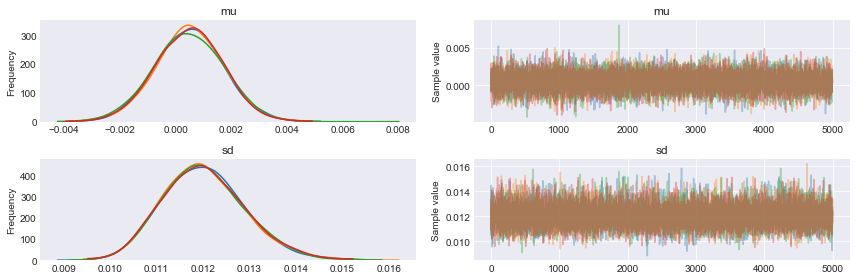

In [12]:
pm.traceplot(trace);

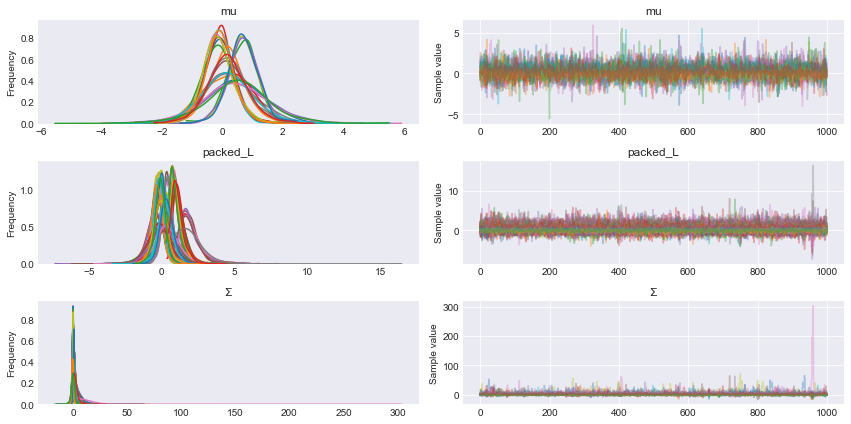

In [13]:
pm.traceplot(trace);

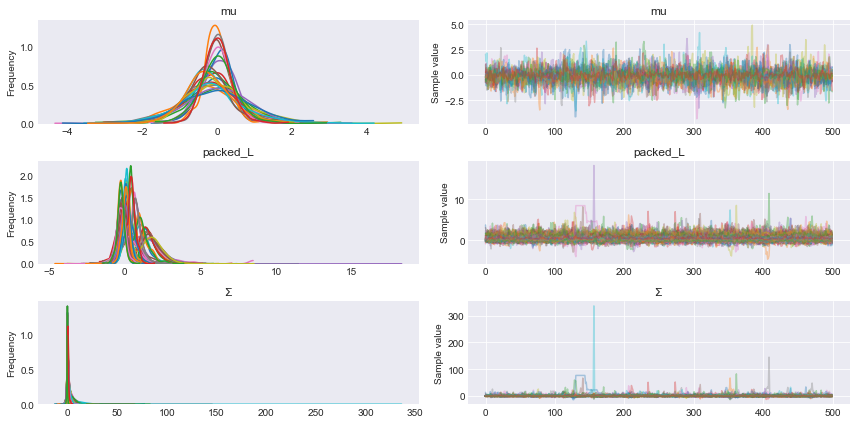

In [11]:
pm.traceplot(trace);

In [19]:
ppc = pm.sample_ppc(trace, samples=1000, model=model, size=500)
r_matrix=np.asarray(ppc['n'])

100%|██████████| 1000/1000 [00:00<00:00, 3533.46it/s]


In [23]:
a=r_matrix.reshape(500000,6)

In [36]:
miu_=np.mean(b)
np.sum(np.sum((a*b),axis=1)-0.5*(np.sum(a*(b-miu_),axis=1))**2)/4

array([ 5, 11])

In [35]:
a*b

array([[1, 4],
       [3, 8]])

In [76]:
np.sum(np.sum((a*b),axis=1)-0.5*(np.sum(a*(b-miu_),axis=1))**2)/4

1.6875

In [75]:
np.sum(a*(b-miu_),axis=1)

array([-2.5,  3.5], dtype=float32)

In [150]:
mu_=np.zeros(6)
cov_=100*np.identity(6)
nu_=5
V_=np.identity(6)
# data=np.array(rets[100:300])
data = np.random.randn(6,6)
with pm.Model() as model:
    mu = pm.MvNormal('mu', mu=mu_, cov=cov_,shape=6)
#     sd = pm.Wishart('sd', nu=nu_,V=V_,shape=(6,6))
#     n = pm.MvNormal('n', mu=mu,cov=np.linalg.inv(sd),observed=data,shape=6)


    packed_L = pm.LKJCholeskyCov('packed_L', n=6,eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
    L = pm.expand_packed_triangular(6, packed_L)
    Σ = pm.Deterministic('Σ', L.dot(L.T))
    n = pm.MvNormal('n', mu=mu,chol=L,observed=data)

#     μ = pm.Normal('μ', 0., 10., shape=2,
#               testval=x.mean(axis=0))
#     obs = pm.MvNormal('obs', μ, chol=L, observed=x)
    trace = pm.sample(50)
    
    
    
    
    
    
    
    

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L_cholesky_cov_packed__, mu]
100%|██████████| 550/550 [00:06<00:00, 88.11it/s]
/usr/local/lib/python3.6/site-packages/pymc3/sampling.py:470: UserWarning: The number of samples is too small to check convergence reliably.
  "The number of samples is too small to check "
The acceptance probability does not match the target. It is 0.6842239418994539, but should be close to 0.8. Try to increase the number of tuning steps.
